In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, mean_absolute_error

In [2]:
title='RNN VCB 8-1-1'
train_ratio=0.8
test_ratio=0.1

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../VCB Historical Data.csv', index_col='Date', parse_dates=['Date'])

In [4]:
df=df.iloc[::-1]
df['Price']=df['Price'].replace(',','',regex=True).astype(float)
df=df['Price']
df1=df.reset_index()['Price']


In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(train_ratio * len(df1))
test_size = int(test_ratio * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [10]:
# 8. Define LSTM Model
unit_model=20
model = Sequential()
model.add(SimpleRNN(unit_model,activation='relu',return_sequences=True,input_shape=(time_step, 1)))
model.add(SimpleRNN(unit_model,activation='relu',return_sequences=True))
model.add(SimpleRNN(unit_model,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
27/27 [==============================] - 2s 22ms/step - loss: 0.0364 - val_loss: 0.0034
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 9.0848e-04 - val_loss: 0.0016
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 8.0675e-04 - val_loss: 0.0013
Epoch 6/100
27/27 [==============================] - 0s 11ms/step - loss: 7.1547e-04 - val_loss: 0.0013
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 6.6497e-04 - val_loss: 0.0014
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 6.7875e-04 - val_loss: 0.0014
Epoch 9/100
27/27 [==============================] - 0s 13ms/step - loss: 6.7283e-04 - val_loss: 0.0013
Epoch 10/100
27/27 [==============================] - 0s 13ms/step - loss: 6

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 3ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
val_len=len(val_data)
print(val_len)

111


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=val_len-60
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.93715155]
52
1 day input [0.82676562 0.87235362 0.90335345 0.87235362 0.90882401 0.92341217
 0.93252977 0.93982385 0.91611809 0.94164737 0.92705921 0.92888273
 0.91247105 0.89058881 0.87235362 0.85776546 0.85958898 0.85776546
 0.8614125  0.8614125  0.85411842 0.86323602 0.85958898 0.84500082
 0.8522949  0.85958898 0.8796477  0.89058881 0.89970641 0.86323602
 0.88694178 0.94529441 0.93252977 0.92705921 0.90882401 0.94164737
 0.92158865 0.93800033 0.94164737 0.9817648  0.96717664 0.94711793
 0.94164737 0.93800033 0.94894145 0.92705921 0.94711793 0.9726472
 0.9635296  0.95441201 0.93715155]
1 day output [[0.923197]]
2 day input [0.87235362 0.90335345 0.87235362 0.90882401 0.92341217 0.93252977
 0.93982385 0.91611809 0.94164737 0.92705921 0.92888273 0.91247105
 0.89058881 0.87235362 0.85776546 0.85958898 0.85776546 0.8614125
 0.8614125  0.85411842 0.86323602 0.85958898 0.84500082 0.8522949
 0.85958898 0.8796477  0.89058881 0.89970641 0.86323602 0.88694178
 0.94529441 0.93252977 0.927059

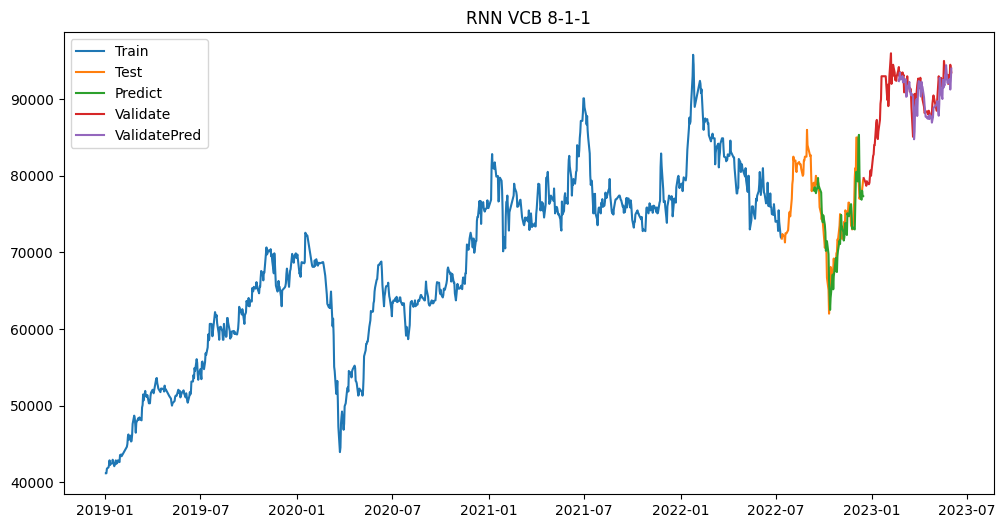

In [16]:
# 14.Vẽ hình
#train
plt.figure(figsize=(12,6))
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
#prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
#plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
#plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title(title)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
#Thực hiện inverse transform để đưa dữ liệu về lại đơn vị ban đầu và tính RMSE và MAPE
y_test_scaleback=scaler.inverse_transform(ytest.reshape(-1,1))
test_mape = mean_absolute_percentage_error(y_test_scaleback, y_pred)*100
test_rmse = np.sqrt(mean_squared_error(y_test_scaleback,y_pred))
test_mae=mean_absolute_error(y_test_scaleback,y_pred)
y_val_scaleback=scaler.inverse_transform(yval.reshape(-1,1))
val_mape = mean_absolute_percentage_error(y_val_scaleback, y_pred_val)*100
val_rmse = np.sqrt(mean_squared_error(y_val_scaleback,y_pred_val))
val_mae=mean_absolute_error(y_val_scaleback,y_pred_val)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)
print("Val RMSE: ",val_rmse)
print("Val MAPE: ",val_mape)
print("Val MAE: ",val_mae)

Testing RMSE: 1706.9192728067537
Testing MAPE: 1.7168270141073527
Testing MAE: 1267.5491961050725
Val RMSE:  1363.3954919130624
Val MAPE:  1.1402001368997357
Val MAE:  1038.7145089285714
